In [1]:
import numpy as np 
import os 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline 

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
path = os.getcwd()
DATA_PATH = "/".join(p for p in path.split(os.path.sep)[:-1]) + "/data/p1ch7/"

cifar10 = datasets.CIFAR10(
    DATA_PATH, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    DATA_PATH, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
connected_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, len(class_names)) # output 10 objects
)

In [5]:
numel_list = [p.numel() for p in connected_model.parameters() if p.requires_grad == True]

sum(numel_list), numel_list

(1640330, [1572864, 512, 65536, 128, 1280, 10])

In [6]:
 conv = nn.Conv2d(3, 16, kernel_size=3)
 conv, conv.weight.shape, conv.bias.shape

(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 torch.Size([16, 3, 3, 3]),
 torch.Size([16]))

In [7]:
img, _ = cifar10[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

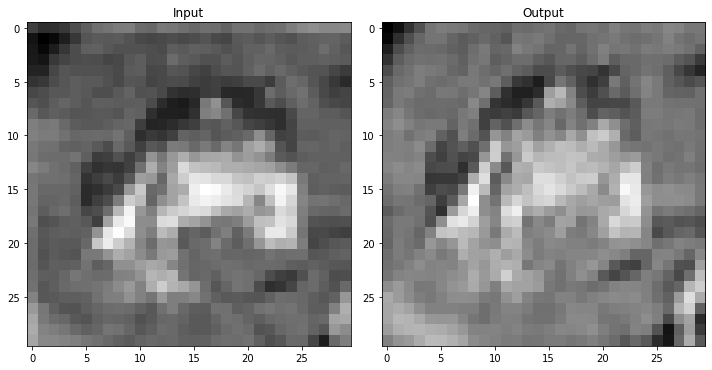

In [8]:
# show output of convolutional layer
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
plt.title('Input')
plt.imshow(img.mean(0), cmap='gray')

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.title('Output')
plt.imshow(output[0, 0].detach(), cmap='gray')

plt.tight_layout()
plt.show()

In [9]:
# vertical edge conv
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

# show result
output_v = conv(img.unsqueeze(0))

# horizontal edge conv
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, -1.0, -1.0],
                                   [0.0, 0.0, 0.0],
                                   [1.0, 1.0, 1.0]])
    conv.bias.zero_()

output_h = conv(img.unsqueeze(0))

# Cross edge conv
with torch.no_grad():
    conv.weight[:] = torch.tensor([[0.0, 1.0, 0.0],
                                   [1.0, 0.0, 1.0],
                                   [0.0, 1.0, 0.0]])
    conv.bias.zero_()

output_c = conv(img.unsqueeze(0))


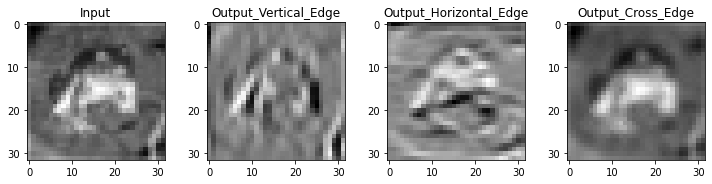

In [10]:
# show output of convolutional layer
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 4, 1)
plt.title('Input')
plt.imshow(img.mean(0), cmap='gray')

plt.subplot(1, 4, 2, sharex=ax1, sharey=ax1)
plt.title('Output_Vertical_Edge')
plt.imshow(output_v[0, 0].detach(), cmap='gray')

plt.subplot(1, 4, 3, sharex=ax1, sharey=ax1)
plt.title('Output_Horizontal_Edge')
plt.imshow(output_h[0, 0].detach(), cmap='gray')


plt.subplot(1, 4, 4, sharex=ax1, sharey=ax1)
plt.title('Output_Cross_Edge')
plt.imshow(output_c[0, 0].detach(), cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    #... some important parts are missing here
    nn.Linear(512, 32),
    nn.MaxPool2d(2),
    nn.Linear(32, len(class_names))
)

In [ ]:
numel = [p.numel() for p in model.parameters()]

numel

In [ ]:
output = model(img.unsqueeze(0))

img.shape, output.view(-1).shape

output of tensor before layer nn.Linear(512, 32) is tensor[[in_c=1, out_c=8, h=8, w=8]] => output of hiddent layer need to be reshaped before fully connected layer (nn.Linear)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.layer2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(512, 32)
        self.act3 = nn.Softmax()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x) 
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(-1, 512)

        x = self.fc1(x)
        x = self.act3(x)

        x = self.fc2(x)

        return x

In [24]:
model = Net()

output = model(img.unsqueeze(0))

output, output.shape, sum(p.numel() for p in model.parameters())

(tensor([[-0.0102, -0.1171,  0.1656, -0.0591,  0.0772,  0.0664,  0.0182,
          -0.0875,  0.0394, -0.0688]], grad_fn=<AddmmBackward>),
 torch.Size([1, 10]),
 18354)

In [32]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=16, shuffle=True)

n_epochs=10
model = Net().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [36]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

print("Training on device {}".format(device))

Training on device cuda


In [41]:
import datetime 

def training(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0 
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch % 10 == 0:    
            print('{} Epoch {:3d}, Loss {:}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))
            

In [37]:
import torch.functional as F 

class Netwidth(nn.Module):
    def __init__(self, in_channel=32, num_classes=10):
        super(Netwidth, self).__init__()

        self.in_channel = in_channel

        self.conv1 = nn.Conv2d(3, in_channel, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(in_channel, in_channel // 2, kernel_size=3, padding=1)
        self.act2 = nn.ReLU() 
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(8 * 8 *in_channel // 2, 32)
        self.act = nn.ReLU() 

        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.act2(out)
        out = self.pool2(out)

        out = out.view(-1, 8 * 8 * self.in_channel // 2)

        out = self.fc1(out)
        out = self.act(out)

        out = self.fc2(out)

        return out


In [42]:
model = Netwidth(in_channel=32).to(device=device)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2020-07-10 11:18:26.123172 Epoch  10, Loss 0.7560994635677337
2020-07-10 11:20:09.215873 Epoch  20, Loss 0.5759956070423127
2020-07-10 11:21:49.679656 Epoch  30, Loss 0.4667074054145813
2020-07-10 11:23:30.469481 Epoch  40, Loss 0.39472288358211516
2020-07-10 11:25:12.828251 Epoch  50, Loss 0.3474109255695343
2020-07-10 11:26:53.930797 Epoch  60, Loss 0.31705922653198243
2020-07-10 11:28:34.781171 Epoch  70, Loss 0.29348189269065855
2020-07-10 11:30:18.761384 Epoch  80, Loss 0.2742886135959625
2020-07-10 11:32:00.802823 Epoch  90, Loss 0.25332423147678373
2020-07-10 11:33:45.666095 Epoch 100, Loss 0.25039532821655275


In [47]:
conv = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=1, groups=1)

conv.weight.shape, conv.bias.shape

(torch.Size([10, 5, 3, 3]), torch.Size([10]))

In [50]:
conv = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=1, groups=5)

conv.weight.shape, conv.bias.shape

(torch.Size([10, 1, 3, 3]), torch.Size([10]))